In [3]:
import pylab
import numpy
from random import random

lib = []
lib.append( lambda *a: a[0]*a[1]+a[2] )
lib.append( lambda *a: a[0]*a[1] )
lib.append( lambda *a: lib[0](a[0],a[1],lib[1](a[0],a[1]))  )

#I would have prefered to use the following code but I can't get it to work (it raises an error when I call lib[2]["function"])
#element = {}
#element["function"] = lambda *a: a[0]*a[1]+a[2]
#element["args"] = ["parameter","variable","parameter"]
#lib.append(element)
#element = {}
#element["function"] = lambda *a: a[0]*a[1]
#element["args"] = ["parameter","variable"]
#lib.append(element)
#element = {}
#element["function"] = lambda *a: lib[0](a[0],a[1],lib[1](a[0],a[1]))
#element["args"] = ["parameter","variable"]
#lib.append(element)

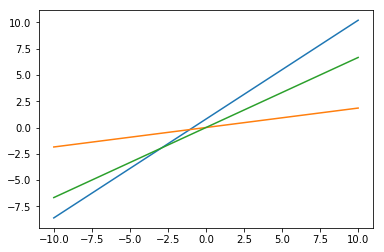

In [4]:
pylab.close()
x = numpy.linspace(-10,10,100)
p = [ random() for i in range(2) ]
g = lambda x: lib[0](p[0],x,p[1])
y = numpy.array([g(xe) for xe in x])
pylab.plot(x,y)
p = [ random() for i in range(1) ]
g = lambda x: lib[1](p[0],x)
y = numpy.array([g(xe) for xe in x])
pylab.plot(x,y)
p = [ random() for i in range(1) ]
g = lambda x: lib[2](p[0],x)
y = numpy.array([g(xe) for xe in x])
pylab.plot(x,y)

pylab.show()

In [ ]:
#for function in lib:
#    args = function["args"]
#    for i, arg in enumerate(args):
#        if arg == "parameter":
#            args[i] = random()
#        else:
#            args[i] = random()
#    g = lambda x: lib[0]["function"](random(),x,random())
#    x = numpy.linspace(-10,10,100)
#    y = numpy.array([g(xe) for xe in x])
#    pylab.plot(x,y)
#
#pylab.show()

In [ ]:
p = [ random() for i in range(2) ]
p